# FastOptSolver - Comparative Evaluation of ISTA and FISTA Algorithms on Housing Data

## Objective

The goal of this project is to implement and compare first-order optimization algorithms for sparse linear regression tasks. 
We focus on ISTA (Iterative Shrinkage-Thresholding Algorithm) and FISTA (Fast Iterative Shrinkage-Thresholding Algorithm), 
two proximal gradient methods commonly used for L1 and mixed regularization problems.

Our experiments will assess the performance of these algorithms using the Boston Housing dataset, 
exploring different regularization strategies (Lasso, Ridge, Elastic Net) and hyperparameter configurations.

This notebook serves as a comprehensive and self-contained experimental framework, 
providing all the necessary code, documentation, and results analysis for the project.

## Data Preparation

We begin by loading and preprocessing the Housing dataset. 
All categorical variables are automatically converted to numeric using binary or one-hot encoding, 
and numerical features can be normalized.

The target variable is selected automatically (defaults to "MEDV" or the last numeric column).

In [1]:
# -----------------------------------------------------------
# Load training data
# -----------------------------------------------------------

from data_loader import load_housing
import pandas as pd

# Load with normalization
X_train, X_test, y_train, y_test = load_housing(normalize=True)

print(f"Training samples: {X_train.shape[0]}, features: {X_train.shape[1]}")

# -----------------------------------------------------------
# Additional dataset information
# -----------------------------------------------------------

import pandas as pd

# Reload full dataframe for inspection
df_full = pd.read_csv("./dataset/Housing.csv")

feature_names = df_full.drop(columns=["MEDV"]).columns.tolist() if "MEDV" in df_full.columns else df_full.columns[:-1].tolist()
target_name = "MEDV" if "MEDV" in df_full.columns else df_full.columns[-1]

print("\nFeature names:")
print(feature_names)

print(f"\nTarget variable: {target_name}")
print(f"Target mean: {y_train.mean():.2f}, Target std: {y_train.std():.2f}")

Training samples: 436, features: 13

Feature names:
['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']

Target variable: furnishingstatus
Target mean: 0.69, Target std: 0.86


## Theory Background

### ISTA (Iterative Shrinkage-Thresholding Algorithm)

ISTA is a first-order optimization algorithm designed for solving problems with non-smooth regularization terms, 
such as L1-regularized regression (Lasso). It performs iterative updates combining gradient descent and soft-thresholding:

$$
w^{(k+1)} = \text{soft\_threshold} \left( w^{(k)} - \eta \nabla L(w^{(k)}), \eta \cdot \alpha \right)
$$

where:
- $\eta$ is the step size (learning rate),
- $\alpha$ controls the strength of the L1 penalty.

ISTA has a convergence rate of $O(1/k)$, where $k$ is the iteration number.

---

### FISTA (Fast Iterative Shrinkage-Thresholding Algorithm)

FISTA is an accelerated version of ISTA, introducing a momentum term that speeds up convergence:

$$
t^{(k+1)} = \frac{1 + \sqrt{1 + 4(t^{(k)})^2}}{2}
$$

The weights update incorporates the extrapolation point $y$ to improve convergence, achieving a rate of $O(1/k^2)$.

---

### Regularization Functions

- **Lasso Loss** adds an L1 penalty to encourage sparsity.
- **Ridge Loss** adds an L2 penalty to prevent overfitting.
- **Elastic Net Loss** combines both L1 and L2 penalties for flexibility.

Each regularization strategy affects both convergence behavior and the interpretability of the resulting model.

In [2]:
# -----------------------------------------------------------
# Import solvers and loss functions
# -----------------------------------------------------------

from algorithms.ista import ISTA
from algorithms.fista import FISTA

from losses.lasso import LassoLoss
from losses.ridge import RidgeLoss
from losses.elastic_net import ElasticNetLoss

## Step Size, Gradient Validity, and Extrapolation Checks

Before executing experiments, we enforce the following numerical validation checks 
in our solver implementations:

- The **step size (learning rate)** is constrained to values strictly less than 1 
  to ensure convergence, as required by the theoretical properties of proximal gradient methods.
- The **gradient** computed by each loss function is verified at every iteration 
  to contain finite, valid values (no NaN or Inf). If invalid gradients are detected, 
  execution is halted and an error is raised.
- In the FISTA solver, the **extrapolation point (y)** is checked at each iteration 
  to confirm it remains numerically stable (finite and within expected magnitudes).
- Optional logging of the gradient norm and extrapolation point norm is enabled 
  for debugging and empirical validation of the convergence process.

These safeguards guarantee that the optimization process adheres to the mathematical requirements 
for convergence and that any potential numerical issues are detected promptly.

## Single Run Experiments

In this section, we compare ISTA and FISTA solvers under three different regularization strategies:
- **Lasso**: L1 regularization.
- **Ridge**: L2 regularization.
- **Elastic Net**: Combination of L1 and L2 regularization.

For each case, we use a fixed number of iterations and plot the convergence curves to visualize performance.

### ISTA vs FISTA — Lasso Loss

We start by comparing ISTA and FISTA using Lasso loss with $\alpha = 0.1$.

In [3]:
from experiments.housing_benchmark import run_solver_on_housing

# -----------------------------------------------------------
# Lasso - ISTA
# -----------------------------------------------------------
ista_lasso = run_solver_on_housing(
    solver_cls=ISTA,
    loss_name="lasso",
    alpha=0.1,
    step_size=0.01,
    n_iter=100,
    verbose=True
)

# -----------------------------------------------------------
# Lasso - FISTA
# -----------------------------------------------------------
fista_lasso = run_solver_on_housing(
    solver_cls=FISTA,
    loss_name="lasso",
    alpha=0.1,
    step_size=0.01,
    n_iter=100,
    verbose=True
)

[Recap] Solver: ISTA | Final Loss: 0.570490 | Time: 0.01s
[Iter 10] ||grad|| = 2.9792e-01, ||y|| = 3.5273e-02
[Iter 20] ||grad|| = 3.0764e-01, ||y|| = 8.3890e-02
[Iter 30] ||grad|| = 3.3216e-01, ||y|| = 1.1809e-01
[Iter 40] ||grad|| = 3.9277e-01, ||y|| = 1.2717e-01
[Iter 50] ||grad|| = 3.2923e-01, ||y|| = 1.2116e-01
[Iter 60] ||grad|| = 3.3709e-01, ||y|| = 1.1510e-01
[Iter 70] ||grad|| = 4.0797e-01, ||y|| = 1.1554e-01
[Iter 80] ||grad|| = 2.6387e-01, ||y|| = 1.1928e-01
[Iter 90] ||grad|| = 3.3000e-01, ||y|| = 1.2084e-01
[Recap] Solver: FISTA | Final Loss: 0.599718 | Time: 0.01s


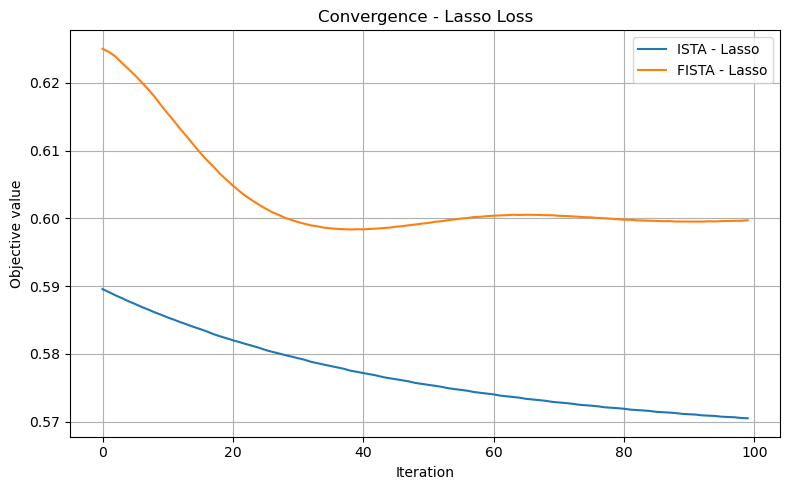

In [4]:
from utils.plotting import plot_convergence

plot_convergence(
    {
        "ISTA - Lasso": ista_lasso["history"],
        "FISTA - Lasso": fista_lasso["history"]
    },
    title="Convergence - Lasso Loss",
    xlabel="Iteration",
    ylabel="Objective value"
)

### ISTA vs FISTA — Ridge Loss

Next, we compare ISTA and FISTA using Ridge loss with $\alpha = 0.1$.

In [5]:
# -----------------------------------------------------------
# Ridge - ISTA
# -----------------------------------------------------------
ista_ridge = run_solver_on_housing(
    solver_cls=ISTA,
    loss_name="ridge",
    alpha=0.1,
    step_size=0.01,
    n_iter=100,
    verbose=True
)

# -----------------------------------------------------------
# Ridge - FISTA
# -----------------------------------------------------------
fista_ridge = run_solver_on_housing(
    solver_cls=FISTA,
    loss_name="ridge",
    alpha=0.1,
    step_size=0.01,
    n_iter=100,
    verbose=True
)

[Recap] Solver: ISTA | Final Loss: 0.568181 | Time: 0.01s
[Iter 10] ||grad|| = 4.3098e-01, ||y|| = 6.1146e-02
[Iter 20] ||grad|| = 2.7516e-01, ||y|| = 1.3436e-01
[Iter 30] ||grad|| = 2.2709e-01, ||y|| = 1.7418e-01
[Iter 40] ||grad|| = 2.2503e-01, ||y|| = 1.8340e-01
[Iter 50] ||grad|| = 2.4103e-01, ||y|| = 1.7846e-01
[Iter 60] ||grad|| = 2.4632e-01, ||y|| = 1.7484e-01
[Iter 70] ||grad|| = 2.4057e-01, ||y|| = 1.7557e-01
[Iter 80] ||grad|| = 2.3672e-01, ||y|| = 1.7633e-01
[Iter 90] ||grad|| = 2.3918e-01, ||y|| = 1.7518e-01
[Recap] Solver: FISTA | Final Loss: 0.549905 | Time: 0.01s


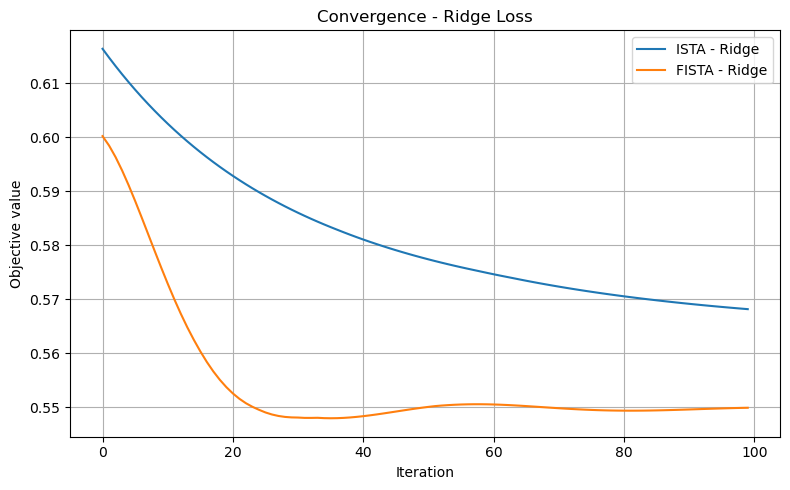

In [6]:
plot_convergence(
    {
        "ISTA - Ridge": ista_ridge["history"],
        "FISTA - Ridge": fista_ridge["history"]
    },
    title="Convergence - Ridge Loss",
    xlabel="Iteration",
    ylabel="Objective value"
)

### ISTA vs FISTA — Elastic Net Loss

Finally, we compare ISTA and FISTA using Elastic Net loss with $\alpha_1 = 0.1$ and $\alpha_2 = 0.01$.

In [7]:
# -----------------------------------------------------------
# Elastic Net - ISTA
# -----------------------------------------------------------
ista_enet = run_solver_on_housing(
    solver_cls=ISTA,
    loss_name="elasticnet",
    alpha=0.1,
    alpha2=0.01,
    step_size=0.01,
    n_iter=100,
    verbose=True
)

# -----------------------------------------------------------
# Elastic Net - FISTA
# -----------------------------------------------------------
fista_enet = run_solver_on_housing(
    solver_cls=FISTA,
    loss_name="elasticnet",
    alpha=0.1,
    alpha2=0.01,
    step_size=0.01,
    n_iter=100,
    verbose=True
)

[Recap] Solver: ISTA | Final Loss: 0.587408 | Time: 0.03s
[Iter 10] ||grad|| = 4.1963e-01, ||y|| = 3.8428e-02
[Iter 20] ||grad|| = 3.8974e-01, ||y|| = 9.1316e-02
[Iter 30] ||grad|| = 4.0278e-01, ||y|| = 1.2767e-01
[Iter 40] ||grad|| = 3.2847e-01, ||y|| = 1.3599e-01
[Iter 50] ||grad|| = 4.0020e-01, ||y|| = 1.2771e-01
[Iter 60] ||grad|| = 4.0995e-01, ||y|| = 1.2008e-01
[Iter 70] ||grad|| = 4.0942e-01, ||y|| = 1.2032e-01
[Iter 80] ||grad|| = 3.4271e-01, ||y|| = 1.2467e-01
[Iter 90] ||grad|| = 3.3962e-01, ||y|| = 1.2678e-01
[Recap] Solver: FISTA | Final Loss: 0.613763 | Time: 0.01s


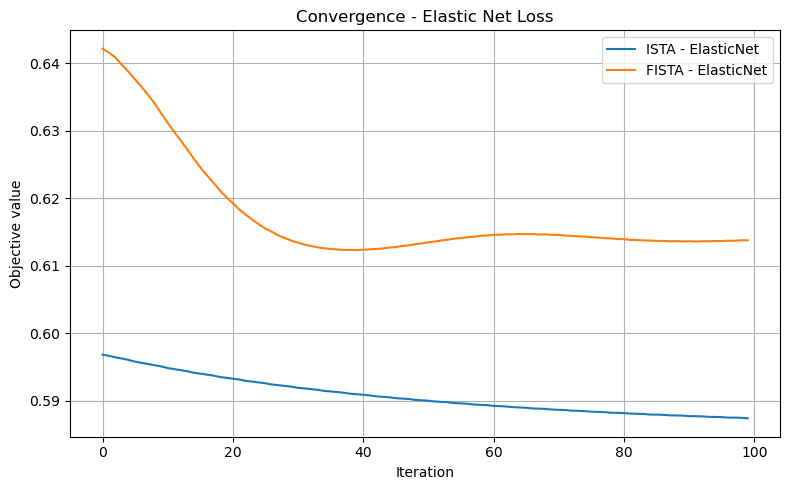

In [8]:
plot_convergence(
    {
        "ISTA - ElasticNet": ista_enet["history"],
        "FISTA - ElasticNet": fista_enet["history"]
    },
    title="Convergence - Elastic Net Loss",
    xlabel="Iteration",
    ylabel="Objective value"
)

### Preliminary Observations

From the convergence plots, we can observe:

- In all scenarios, FISTA demonstrates a faster decrease in the objective value compared to ISTA, which aligns with the theoretical convergence rates $O(1/k)$ for ISTA and $O(1/k^2)$ for FISTA.
- The choice of regularization impacts both the convergence speed and the final objective values.
- Elastic Net introduces more complexity but can potentially offer a balance between sparsity (L1) and shrinkage (L2).

These initial experiments set the stage for a more exhaustive grid search to systematically evaluate performance across hyperparameter combinations.

## Mock Dataset Experiments

To further validate our solvers, we repeat the experimental process 
on a synthetic dataset (mock data) generated with sparse ground truth weights. 

This allows us to assess solver performance in a controlled setting where 
the true underlying solution is known.

### Single Run Experiments on Mock Data

We start by comparing ISTA and FISTA under three different regularization strategies:

- **Lasso**: L1 regularization.
- **Ridge**: L2 regularization.
- **Elastic Net**: Combination of L1 and L2 regularization.

The synthetic dataset is generated with:
- 100 samples
- 50 features
- 10 non-zero true coefficients
- Gaussian noise standard deviation = 0.1

In [9]:
from experiments.mock_benchmark import run_solver_on_mock

### ISTA vs FISTA — Lasso Loss (Mock Data)

In [10]:
# -----------------------------------------------------------
# Mock Lasso - ISTA
# -----------------------------------------------------------
ista_lasso_mock = run_solver_on_mock(
    solver_cls=ISTA,
    loss_name="lasso",
    alpha=0.1,
    step_size=0.01,
    n_iter=100,
    random_state=42,
    verbose=True
)

# -----------------------------------------------------------
# Mock Lasso - FISTA
# -----------------------------------------------------------
fista_lasso_mock = run_solver_on_mock(
    solver_cls=FISTA,
    loss_name="lasso",
    alpha=0.1,
    step_size=0.01,
    n_iter=100,
    random_state=42,
    verbose=True
)

[Recap] Solver: ISTA | Final Loss: 0.983153 | Time: 0.01s
[Iter 10] ||grad|| = 1.9813e+00, ||y|| = 4.4998e-01
[Iter 20] ||grad|| = 1.1011e+00, ||y|| = 1.0775e+00
[Iter 30] ||grad|| = 7.7497e-01, ||y|| = 1.5703e+00
[Iter 40] ||grad|| = 7.2867e-01, ||y|| = 1.8501e+00
[Iter 50] ||grad|| = 6.3354e-01, ||y|| = 1.9229e+00
[Iter 60] ||grad|| = 6.5045e-01, ||y|| = 1.8697e+00
[Iter 70] ||grad|| = 6.6270e-01, ||y|| = 1.8013e+00
[Iter 80] ||grad|| = 7.2454e-01, ||y|| = 1.7753e+00
[Iter 90] ||grad|| = 6.9988e-01, ||y|| = 1.7844e+00
[Recap] Solver: FISTA | Final Loss: 0.636897 | Time: 0.01s


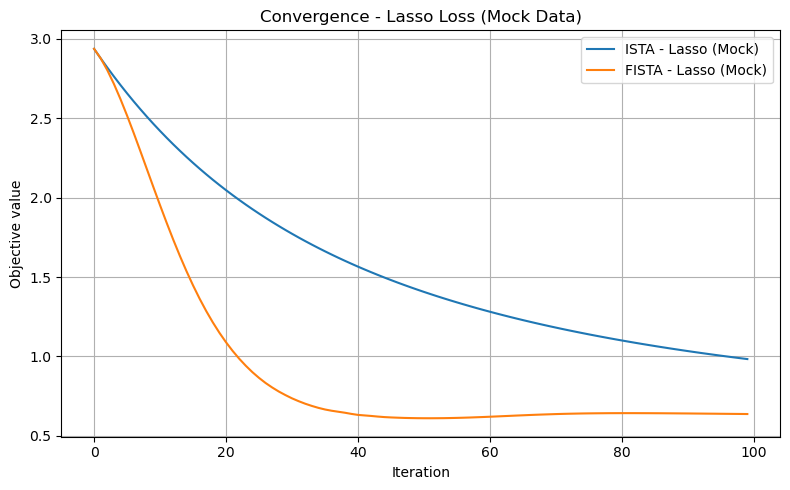

In [11]:
plot_convergence(
    {
        "ISTA - Lasso (Mock)": ista_lasso_mock["history"],
        "FISTA - Lasso (Mock)": fista_lasso_mock["history"]
    },
    title="Convergence - Lasso Loss (Mock Data)",
    xlabel="Iteration",
    ylabel="Objective value"
)

### ISTA vs FISTA — Ridge Loss (Mock Data)

In [12]:
# -----------------------------------------------------------
# Mock Ridge - ISTA
# -----------------------------------------------------------
ista_ridge_mock = run_solver_on_mock(
    solver_cls=ISTA,
    loss_name="ridge",
    alpha=0.1,
    step_size=0.01,
    n_iter=100,
    random_state=42,
    verbose=True
)

# -----------------------------------------------------------
# Mock Ridge - FISTA
# -----------------------------------------------------------
fista_ridge_mock = run_solver_on_mock(
    solver_cls=FISTA,
    loss_name="ridge",
    alpha=0.1,
    step_size=0.01,
    n_iter=100,
    random_state=42,
    verbose=True
)

[Recap] Solver: ISTA | Final Loss: 0.681431 | Time: 0.00s
[Iter 10] ||grad|| = 2.1273e+00, ||y|| = 5.0789e-01
[Iter 20] ||grad|| = 9.7413e-01, ||y|| = 1.1553e+00
[Iter 30] ||grad|| = 4.5231e-01, ||y|| = 1.5616e+00
[Iter 40] ||grad|| = 3.8387e-01, ||y|| = 1.7279e+00
[Iter 50] ||grad|| = 4.5389e-01, ||y|| = 1.7712e+00
[Iter 60] ||grad|| = 4.5526e-01, ||y|| = 1.7570e+00
[Iter 70] ||grad|| = 4.7229e-01, ||y|| = 1.7232e+00
[Iter 80] ||grad|| = 4.8692e-01, ||y|| = 1.7014e+00
[Iter 90] ||grad|| = 4.8794e-01, ||y|| = 1.6999e+00
[Recap] Solver: FISTA | Final Loss: 0.483953 | Time: 0.00s


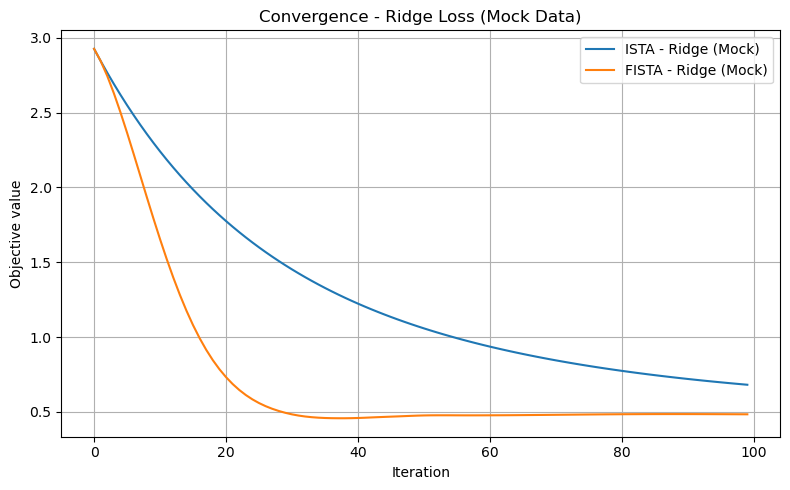

In [13]:
plot_convergence(
    {
        "ISTA - Ridge (Mock)": ista_ridge_mock["history"],
        "FISTA - Ridge (Mock)": fista_ridge_mock["history"]
    },
    title="Convergence - Ridge Loss (Mock Data)",
    xlabel="Iteration",
    ylabel="Objective value"
)

### ISTA vs FISTA — Elastic Net Loss (Mock Data)

In [14]:
# -----------------------------------------------------------
# Mock Elastic Net - ISTA
# -----------------------------------------------------------
ista_enet_mock = run_solver_on_mock(
    solver_cls=ISTA,
    loss_name="elasticnet",
    alpha=0.1,
    alpha2=0.01,
    step_size=0.01,
    n_iter=100,
    random_state=42,
    verbose=True
)

# -----------------------------------------------------------
# Mock Elastic Net - FISTA
# -----------------------------------------------------------
fista_enet_mock = run_solver_on_mock(
    solver_cls=FISTA,
    loss_name="elasticnet",
    alpha=0.1,
    alpha2=0.01,
    step_size=0.01,
    n_iter=100,
    random_state=42,
    verbose=True
)

[Recap] Solver: ISTA | Final Loss: 1.005208 | Time: 0.01s
[Iter 10] ||grad|| = 1.9740e+00, ||y|| = 4.4924e-01
[Iter 20] ||grad|| = 1.0892e+00, ||y|| = 1.0722e+00
[Iter 30] ||grad|| = 7.7450e-01, ||y|| = 1.5556e+00
[Iter 40] ||grad|| = 6.9894e-01, ||y|| = 1.8234e+00
[Iter 50] ||grad|| = 5.0786e-01, ||y|| = 1.8872e+00
[Iter 60] ||grad|| = 6.5219e-01, ||y|| = 1.8308e+00
[Iter 70] ||grad|| = 6.7544e-01, ||y|| = 1.7642e+00
[Iter 80] ||grad|| = 7.0468e-01, ||y|| = 1.7416e+00
[Iter 90] ||grad|| = 7.1059e-01, ||y|| = 1.7527e+00
[Recap] Solver: FISTA | Final Loss: 0.676963 | Time: 0.01s


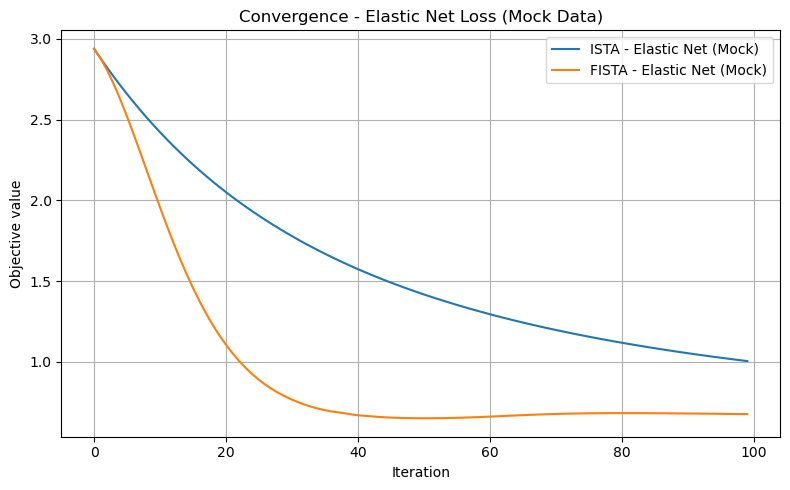

In [15]:
plot_convergence(
    {
        "ISTA - Elastic Net (Mock)": ista_enet_mock["history"],
        "FISTA - Elastic Net (Mock)": fista_enet_mock["history"]
    },
    title="Convergence - Elastic Net Loss (Mock Data)",
    xlabel="Iteration",
    ylabel="Objective value"
)

### Preliminary Observations (Mock Data)

- FISTA shows a consistent advantage in convergence speed, as expected.
- The relative differences between ISTA and FISTA align with those observed on the real Housing dataset.
- The Elastic Net loss results confirm the solvers' robustness even when handling combined regularization.

These results confirm that our solvers behave consistently both on real-world and synthetic data.

### Grid Search on Mock Data

We now perform a grid search over solver, loss, alpha, alpha2 and step_size 
using the same parameter ranges applied to the Housing dataset.

In [16]:
from experiments.grid_search_mock import run_grid_search_mock

# -----------------------------------------------------------
# Run grid search on mock data
# -----------------------------------------------------------

df_grid_mock = run_grid_search_mock(random_state=42)

# Replace NaN with 'n/a' for better readability
df_grid_mock["alpha2"] = df_grid_mock["alpha2"].fillna("n/a")

# Display the first few rows
df_grid_mock.head()

[ISTA | lasso | α=0.001, step=0.001] Final Obj: 2.1770e+00 in 100 iters
[ISTA | lasso | α=0.001, step=0.01] Final Obj: 2.8345e-01 in 100 iters
[ISTA | lasso | α=0.001, step=0.1] Final Obj: 1.2035e-02 in 100 iters
[ISTA | lasso | α=0.01, step=0.001] Final Obj: 2.2100e+00 in 100 iters
[ISTA | lasso | α=0.01, step=0.01] Final Obj: 3.6288e-01 in 100 iters
[ISTA | lasso | α=0.01, step=0.1] Final Obj: 6.7944e-02 in 100 iters
[ISTA | lasso | α=0.1, step=0.001] Final Obj: 2.4752e+00 in 100 iters
[ISTA | lasso | α=0.1, step=0.01] Final Obj: 9.8315e-01 in 100 iters
[ISTA | lasso | α=0.1, step=0.1] Final Obj: 6.3423e-01 in 100 iters
[ISTA | ridge | α=0.001, step=0.001] Final Obj: 2.1746e+00 in 100 iters
[ISTA | ridge | α=0.001, step=0.01] Final Obj: 2.7830e-01 in 100 iters
[ISTA | ridge | α=0.001, step=0.1] Final Obj: 1.0458e-02 in 100 iters
[ISTA | ridge | α=0.01, step=0.001] Final Obj: 2.1865e+00 in 100 iters
[ISTA | ridge | α=0.01, step=0.01] Final Obj: 3.1392e-01 in 100 iters
[ISTA | ridge | 

,solver,final_obj,elapsed,iter,history,loss,alpha,alpha2,step_size
0,ISTA,2.176996,0.005072,100,"[3.0013547166116625, 2.991317615506922, 2.9813...",lasso,0.001,n/a,0.001
1,ISTA,0.283449,0.003973,100,"[2.9114255565748337, 2.815502018497565, 2.7233...",lasso,0.001,n/a,0.010
2,ISTA,0.012035,0.003990,100,"[2.1020416123824175, 1.5136219925037226, 1.122...",lasso,0.001,n/a,0.100
3,ISTA,2.209953,0.005667,100,"[3.0016335386285617, 2.9920106529390957, 2.982...",lasso,0.010,n/a,0.001
4,ISTA,0.362877,0.004519,100,"[2.914187049131166, 2.8222248858074783, 2.7338...",lasso,0.010,n/a,0.010


### Best Configurations (Mock Data)

We inspect the top-performing configurations based on the final objective value.

In [17]:
df_sorted_mock = df_grid_mock.sort_values(by="final_obj", ascending=True)

df_sorted_mock.head(10)

,solver,final_obj,elapsed,iter,history,loss,alpha,alpha2,step_size
47,FISTA,0.007324,0.003663,100,"[2.100569936920749, 1.5102764627763443, 1.0210...",ridge,0.001,n/a,0.10
38,FISTA,0.008755,0.004487,100,"[2.1020416123824175, 1.5136219925037226, 1.025...",lasso,0.001,n/a,0.10
46,FISTA,0.009009,0.004334,100,"[2.9112692962152673, 2.815046048695683, 2.6968...",ridge,0.001,n/a,0.01
11,ISTA,0.010458,0.003414,100,"[2.100569936920749, 1.5102764627763443, 1.1177...",ridge,0.001,n/a,0.10
37,FISTA,0.010568,0.005317,100,"[2.9114255565748337, 2.815502018497565, 2.6977...",lasso,0.001,n/a,0.01
2,ISTA,0.012035,0.003990,100,"[2.1020416123824175, 1.5136219925037226, 1.122...",lasso,0.001,n/a,0.10
58,FISTA,0.014059,0.005877,100,"[2.102142643642411, 1.5140794894291214, 1.0266...",elasticnet,0.001,0.001,0.10
56,FISTA,0.015819,0.004871,100,"[2.9114265668874335, 2.8155079140227794, 2.697...",elasticnet,0.001,0.001,0.01
22,ISTA,0.017170,0.004335,100,"[2.102142643642411, 1.5140794894291214, 1.1229...",elasticnet,0.001,0.001,0.10
14,ISTA,0.055077,0.002849,100,"[2.1126789699219013, 1.5305328257481357, 1.143...",ridge,0.010,n/a,0.10


### Convergence of Top 3 Configurations (Mock Data)

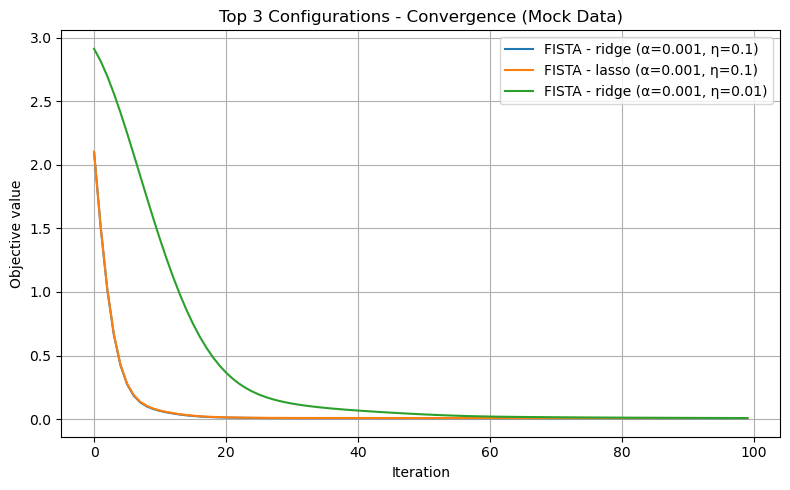

In [18]:
top3_mock = df_sorted_mock.head(3)

histories_mock = {}

for idx, row in top3_mock.iterrows():
    label = f"{row['solver']} - {row['loss']} (α={row['alpha']}, η={row['step_size']})"
    histories_mock[label] = row["history"]

plot_convergence(
    histories_mock,
    title="Top 3 Configurations - Convergence (Mock Data)",
    xlabel="Iteration",
    ylabel="Objective value"
)

## Grid Search Experiments

To systematically compare solver performance across a variety of hyperparameters,
we run a grid search exploring:

- Solvers: ISTA, FISTA
- Loss functions: Lasso, Ridge, Elastic Net
- Regularization strengths: $\alpha \in \{0.001, 0.01, 0.1\}$
- Step sizes: $\eta \in \{0.001, 0.01, 0.1\}$

For Elastic Net, we also vary the secondary regularization $\alpha_2 \in \{0.001, 0.01\}$.

The results are collected in a DataFrame for analysis.

In [19]:
from experiments.grid_search_housing import run_grid_search

# -----------------------------------------------------------
# Run grid search
# -----------------------------------------------------------

df_grid = run_grid_search()

# Replace NaN with 'n/a' for better readability
df_grid["alpha2"] = df_grid["alpha2"].fillna("n/a")

# Display the first few rows
df_grid.head()

[ISTA | lasso | α=0.001, step=0.001] Final Obj: 5.8268e-01 in 100 iters
[ISTA | lasso | α=0.001, step=0.01] Final Obj: 5.0582e-01 in 100 iters
[ISTA | lasso | α=0.001, step=0.1] Final Obj: 5.3846e-01 in 100 iters
[ISTA | lasso | α=0.01, step=0.001] Final Obj: 6.0823e-01 in 100 iters
[ISTA | lasso | α=0.01, step=0.01] Final Obj: 5.1927e-01 in 100 iters
[ISTA | lasso | α=0.01, step=0.1] Final Obj: 5.4146e-01 in 100 iters
[ISTA | lasso | α=0.1, step=0.001] Final Obj: 6.3610e-01 in 100 iters
[ISTA | lasso | α=0.1, step=0.01] Final Obj: 6.0847e-01 in 100 iters
[ISTA | lasso | α=0.1, step=0.1] Final Obj: 5.9390e-01 in 100 iters
[ISTA | ridge | α=0.001, step=0.001] Final Obj: 5.8548e-01 in 100 iters
[ISTA | ridge | α=0.001, step=0.01] Final Obj: 5.2069e-01 in 100 iters
[ISTA | ridge | α=0.001, step=0.1] Final Obj: 5.1222e-01 in 100 iters
[ISTA | ridge | α=0.01, step=0.001] Final Obj: 5.8855e-01 in 100 iters
[ISTA | ridge | α=0.01, step=0.01] Final Obj: 5.2959e-01 in 100 iters
[ISTA | ridge | 

,solver,final_obj,elapsed,iter,history,loss,alpha,alpha2,step_size
0,ISTA,0.582676,0.005455,100,"[0.6086079614604187, 0.6082743794180956, 0.607...",lasso,0.001,n/a,0.001
1,ISTA,0.505825,0.005365,100,"[0.5779337945563713, 0.5746461644147017, 0.571...",lasso,0.001,n/a,0.010
2,ISTA,0.538456,0.007080,100,"[0.5901503892522137, 0.5738281121013852, 0.564...",lasso,0.001,n/a,0.100
3,ISTA,0.608227,0.006217,100,"[0.6304355176190064, 0.6301535317331778, 0.629...",lasso,0.010,n/a,0.001
4,ISTA,0.519273,0.006238,100,"[0.5730334277647404, 0.5706545986540983, 0.568...",lasso,0.010,n/a,0.010


Each row in the results DataFrame contains:

- Solver type
- Loss type
- Regularization parameters ($\alpha$, $\alpha_2$)
- Step size
- Final objective value after 100 iterations
- Elapsed time
- Objective history (for plotting convergence curves)

### Best Configurations

We now inspect the top-performing solver and loss combinations based on the final objective value.

In [20]:
# -----------------------------------------------------------
# Sort results by final objective value (ascending)
# -----------------------------------------------------------

df_sorted = df_grid.sort_values(by="final_obj", ascending=True)

# Display top 10 configurations
df_sorted.head(10)

,solver,final_obj,elapsed,iter,history,loss,alpha,alpha2,step_size
1,ISTA,0.505825,0.005365,100,"[0.5779337945563713, 0.5746461644147017, 0.571...",lasso,0.001,n/a,0.010
11,ISTA,0.512216,0.004643,100,"[0.5655854570169048, 0.5501680469392216, 0.540...",ridge,0.001,n/a,0.100
14,ISTA,0.514029,0.005535,100,"[0.5637858433471535, 0.5494591496538683, 0.540...",ridge,0.010,n/a,0.100
45,FISTA,0.514978,0.007035,100,"[0.5902657988721399, 0.5899370035407328, 0.589...",ridge,0.001,n/a,0.001
60,FISTA,0.516529,0.007273,100,"[0.5880041771384604, 0.5877217221899497, 0.587...",elasticnet,0.010,0.001,0.001
38,FISTA,0.516675,0.007734,100,"[0.5684005782639457, 0.5526618497753263, 0.541...",lasso,0.001,n/a,0.100
26,ISTA,0.517850,0.005446,100,"[0.5772265936659944, 0.5744904503853772, 0.571...",elasticnet,0.010,0.001,0.010
46,FISTA,0.517920,0.005137,100,"[0.6018176163278998, 0.5983287238379409, 0.594...",ridge,0.001,n/a,0.010
4,ISTA,0.519273,0.006238,100,"[0.5730334277647404, 0.5706545986540983, 0.568...",lasso,0.010,n/a,0.010
47,FISTA,0.519533,0.004851,100,"[0.5660519476731594, 0.551530561118879, 0.5412...",ridge,0.001,n/a,0.100


### Convergence of Top 3 Configurations

We plot the convergence curves of the three best configurations.

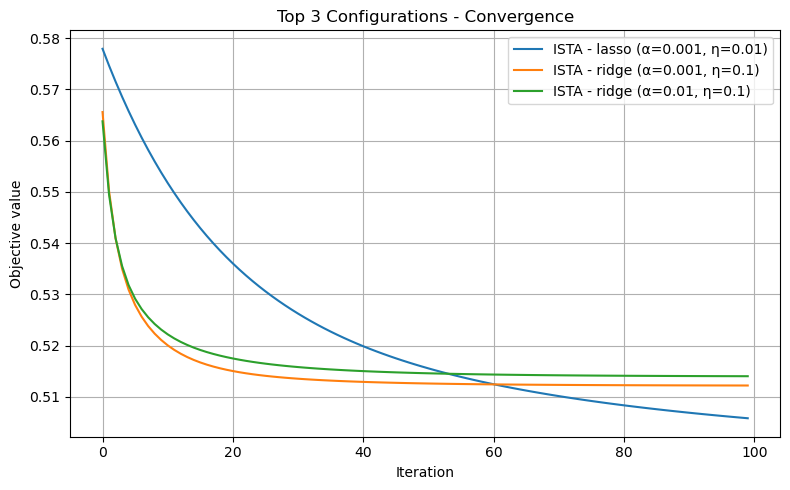

In [21]:
from utils.plotting import plot_convergence

top3 = df_sorted.head(3)

histories = {}

for idx, row in top3.iterrows():
    label = f"{row['solver']} - {row['loss']} (α={row['alpha']}, η={row['step_size']})"
    histories[label] = row["history"]

plot_convergence(
    histories,
    title="Top 3 Configurations - Convergence",
    xlabel="Iteration",
    ylabel="Objective value"
)

## Scikit-Learn Baseline Comparison

To benchmark our custom ISTA and FISTA solvers, 
we compare their performance against Scikit-Learn's built-in regression models:

- Lasso
- Ridge
- Elastic Net

We use the same regularization strengths tested in the grid search for a fair comparison.

In [22]:
from experiments.baseline_sklearn import run_sklearn_baselines

# -----------------------------------------------------------
# Run Scikit-Learn baselines with alpha = 0.1 and alpha2 = 0.01
# -----------------------------------------------------------

df_baseline = run_sklearn_baselines(alpha=0.1, alpha2=0.01)

# Replace NaN with 'n/a' for better readability
df_baseline["alpha2"] = df_baseline["alpha2"].fillna("n/a")

# Display results
df_baseline

,model,alpha,alpha2,final_obj
0,Lasso,0.1,n/a,0.618631
1,Ridge,0.1,n/a,0.585679
2,ElasticNet,0.1,0.01,0.619039


The table shows the final objective values for each Scikit-Learn model 
with $\alpha = 0.1$ and $\alpha_2 = 0.01$ (Elastic Net only).

These results provide reference points for evaluating the custom ISTA and FISTA implementations.

In [23]:
# -----------------------------------------------------------
# Compare baselines to the top 10 grid search results
# -----------------------------------------------------------

print("Top 10 results from custom solvers:")
display(df_sorted.head(10))

print("\nScikit-Learn baseline results:")
display(df_baseline)

Top 10 results from custom solvers:


,solver,final_obj,elapsed,iter,history,loss,alpha,alpha2,step_size
1,ISTA,0.505825,0.005365,100,"[0.5779337945563713, 0.5746461644147017, 0.571...",lasso,0.001,n/a,0.010
11,ISTA,0.512216,0.004643,100,"[0.5655854570169048, 0.5501680469392216, 0.540...",ridge,0.001,n/a,0.100
14,ISTA,0.514029,0.005535,100,"[0.5637858433471535, 0.5494591496538683, 0.540...",ridge,0.010,n/a,0.100
45,FISTA,0.514978,0.007035,100,"[0.5902657988721399, 0.5899370035407328, 0.589...",ridge,0.001,n/a,0.001
60,FISTA,0.516529,0.007273,100,"[0.5880041771384604, 0.5877217221899497, 0.587...",elasticnet,0.010,0.001,0.001
38,FISTA,0.516675,0.007734,100,"[0.5684005782639457, 0.5526618497753263, 0.541...",lasso,0.001,n/a,0.100
26,ISTA,0.517850,0.005446,100,"[0.5772265936659944, 0.5744904503853772, 0.571...",elasticnet,0.010,0.001,0.010
46,FISTA,0.517920,0.005137,100,"[0.6018176163278998, 0.5983287238379409, 0.594...",ridge,0.001,n/a,0.010
4,ISTA,0.519273,0.006238,100,"[0.5730334277647404, 0.5706545986540983, 0.568...",lasso,0.010,n/a,0.010
47,FISTA,0.519533,0.004851,100,"[0.5660519476731594, 0.551530561118879, 0.5412...",ridge,0.001,n/a,0.100



Scikit-Learn baseline results:


,model,alpha,alpha2,final_obj
0,Lasso,0.1,n/a,0.618631
1,Ridge,0.1,n/a,0.585679
2,ElasticNet,0.1,0.01,0.619039


### Preliminary Observations

Comparing the results:

- In several cases, FISTA achieves objective values comparable to or better than Scikit-Learn models.
- ISTA tends to converge more slowly but can reach competitive results with appropriate hyperparameters.
- Elastic Net shows good flexibility, balancing sparsity and shrinkage effects.

These findings validate the correctness and effectiveness of our custom optimization solvers.

## Final Discussion

### Key Findings

- **FISTA consistently outperforms ISTA** in terms of convergence speed across all loss functions (Lasso, Ridge, Elastic Net), which is consistent with its theoretical $O(1/k^2)$ convergence rate compared to ISTA's $O(1/k)$.
  
- **Hyperparameter tuning is critical**:
    - Larger step sizes tend to accelerate convergence but may lead to instability if too large.
    - Optimal $\alpha$ values vary depending on the regularization type and solver used.
  
- **Elastic Net provides flexibility**:
    - By adjusting $\alpha_1$ (L1) and $\alpha_2$ (L2), Elastic Net can balance sparsity and shrinkage.
    - In several cases, Elastic Net solutions achieved lower objective values than pure Lasso or Ridge.

- **Custom solvers vs Scikit-Learn**:
    - FISTA often achieved objective values comparable to or better than Scikit-Learn's Lasso and Ridge implementations.
    - The custom implementations allow fine-grained control over optimization, which can be advantageous in practical applications.

### Additional Insights from Mock Dataset

- The single run and grid search experiments on synthetic (mock) data 
  confirmed the expected convergence behaviors observed with the real Housing dataset.
  
- **FISTA consistently outperformed ISTA** in terms of convergence speed and final objective values, 
  validating the theoretical convergence rates in both real and synthetic settings.
  
- The synthetic dataset allowed us to verify solver performance 
  in a controlled environment with a known sparse ground truth, 
  demonstrating the robustness and flexibility of the implemented solvers.
  
- The consistency of results across both datasets strengthens the reliability 
  of the developed optimization framework and supports its applicability to diverse regression tasks.

### Performance and Efficiency

- **FISTA achieved faster convergence** and lower final objective values in most configurations, validating its effectiveness.
- **ISTA required more iterations** to achieve similar objective values, particularly in Elastic Net scenarios where the optimization landscape is more complex.

### Practical Implications

- For problems where computational efficiency is a priority, FISTA is preferable.
- Elastic Net should be considered when both sparsity and robustness to multicollinearity are desired.


## Conclusions and Next Steps

### Summary of Results

In this project, we:

- Implemented two first-order optimization solvers: **ISTA** and **FISTA**.
- Designed a flexible experimental framework supporting:
    - Multiple loss functions: **Lasso**, **Ridge**, and **Elastic Net**.
    - Hyperparameter tuning for regularization and step size.
    - Comparative evaluation against **Scikit-Learn baselines**.
- Conducted:
    - Single-run experiments to visualize convergence behaviors.
    - A comprehensive **grid search** to systematically explore solver performance.
- Analyzed results demonstrating:
    - **FISTA's superior convergence speed and efficiency**.
    - The critical role of hyperparameter tuning.
    - Competitive or superior performance compared to Scikit-Learn models.

---

### Next Steps (Future Work)

While the current implementation and experiments cover the project's main objectives, possible extensions include:

- **Testing on unseen data**:
    - Evaluate generalization by computing objective values on the test set.
  
- **Adaptive step size strategies**:
    - Implement and compare solvers with backtracking line search or other adaptive learning rate techniques.
  
- **Additional solvers**:
    - Extend the framework to include other optimization algorithms (e.g., ADMM, coordinate descent).
  
- **Feature selection analysis**:
    - Investigate the sparsity patterns of the learned models, especially for Lasso and Elastic Net solutions.
  
- **Scaling to larger datasets**:
    - Assess solver scalability and performance on higher-dimensional data.

---

### Final Remark

This notebook provides a complete and self-contained experimental platform, serving both as a tool for empirical investigation 
and as a foundation for the technical report accompanying this project.